<a href="https://colab.research.google.com/github/SwareenaDixit/DistractedDriverDetection/blob/main/Edvancer_Distracted_Driver_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4 : Distracted Driver MultiAction Classification
Goal : Build a model to classify images into these 10 classes:
*   c0: safe driving
*   c1: texting - right
*   c2: talking on the phone - right
*   c3: texting - left
*   c4: talking on the phone - left
*   c5: operating the radio
*   c6: drinking
*   c7: reaching behind
*   c8: hair and makeup
*   c9: talking to passenger

Data: The dataset contains 22424 unique images with their class labels 10 class labels.

Train-Validation-Test Split: The data has been split into Train-Validation sets in the ratio 70:30, stratified on the class label column. Test data of 79726 images has been provided.

Model: A CNN architecture with three convolutional blocks, each containing two convolutional layers with batch normalization, followed by max-pooling and dropout. The output is then flattened and passed through two fully connected layers with dropout, and finally, there's a 10-class softmax output layer.



In [26]:
# Import libraries
import os
import cv2
import io
import gc
import requests
import random
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras import utils
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
!wget -O state-farm-distracted-driver-detection.zip https://www.dropbox.com/s/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip?dl=0

--2023-10-24 10:19:29--  https://www.dropbox.com/s/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip [following]
--2023-10-24 10:19:30--  https://www.dropbox.com/s/raw/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3fccac57b3f17556508e92b842.dl.dropboxusercontent.com/cd/0/inline/CGOai1psFoxwg91Y15x4S4kICNGH6xLhDoZwuAA5RQGi6okyeV79EJIBVpBHdmtsryKdSYU3k9Y7URcP0vIwT3sBXnqgdzvWJq2F9V5WRMcWGPDF1vlRN3lB4wiBXTNu_DM/file# [following]
--2023-10-24 10:19:30--  https://uc3fccac57b3f17556508e92b842.dl.dropboxusercontent.com/cd/0/inline/CGOai1psFoxwg91Y15x4S4kICNGH

In [3]:
# Load Data
zip_file_path = '/content/state-farm-distracted-driver-detection.zip'
extract_path = '/content/sample_data/distracted_drver_data'
with ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

zip_file_path = '/content/sample_data/distracted_drver_data/imgs.zip'
extract_path = '/content/sample_data/distracted_drver_data/images'
with ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
sample_submission = pd.read_csv('/content/sample_data/distracted_drver_data/sample_submission.csv')

In [ ]:
sample_submission.head()

img   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
0       img_1.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
1      img_10.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
2     img_100.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
3    img_1000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
4  img_100000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1

In [3]:
# Defining Constants.
directory = '/content/sample_data/distracted_drver_data/images/train'
test_directory = '/content/sample_data/distracted_drver_data/images/test'
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
classes_dict = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'
}

# defining a shape to be used for our models.
img_size = 240

In [71]:
# Check training and testing images count
train_count = 0
for class_name in classes_dict.keys():
  class_count = len(os.listdir(os.path.join(directory, class_name)))
  train_count += class_count
  print(f"Training Images {[class_name]}: {class_count}")
print(f"Total Training Images: {train_count}")
print(f"Testing Images: {len(os.listdir(test_directory))}")

Training Images ['c0']: 2489
Training Images ['c1']: 2267
Training Images ['c2']: 2317
Training Images ['c3']: 2346
Training Images ['c4']: 2326
Training Images ['c5']: 2312
Training Images ['c6']: 2325
Training Images ['c7']: 2002
Training Images ['c8']: 1911
Training Images ['c9']: 2129
Total Training Images: 22424
Testing Images: 79726


c0: safe driving


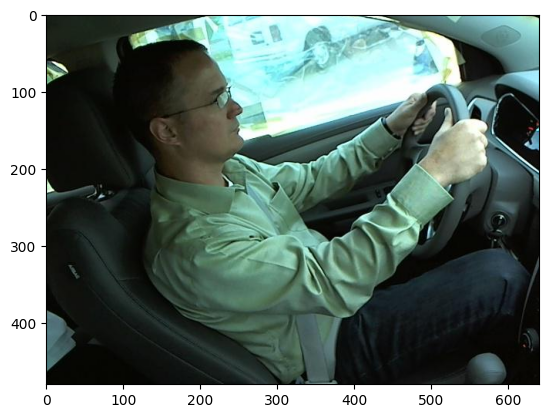

c1: texting - right


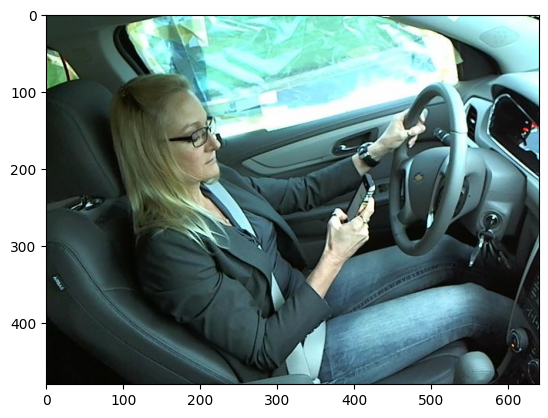

c2: talking on the phone - right


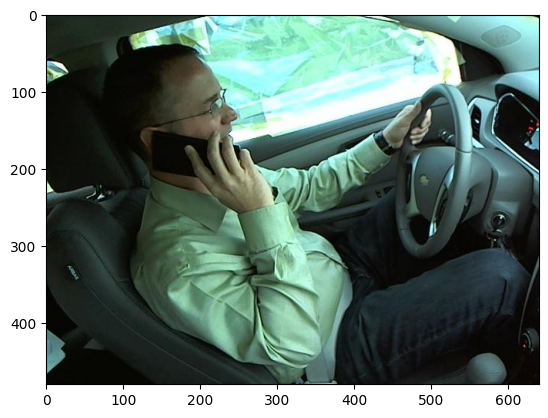

c3: texting - left


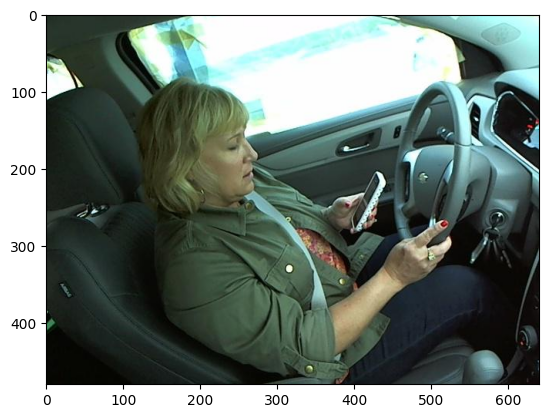

c4: talking on the phone - left


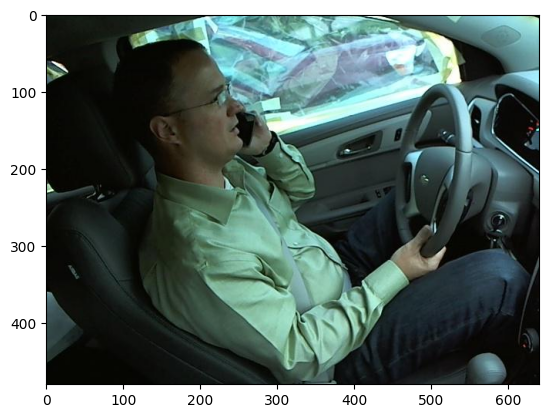

c5: operating the radio


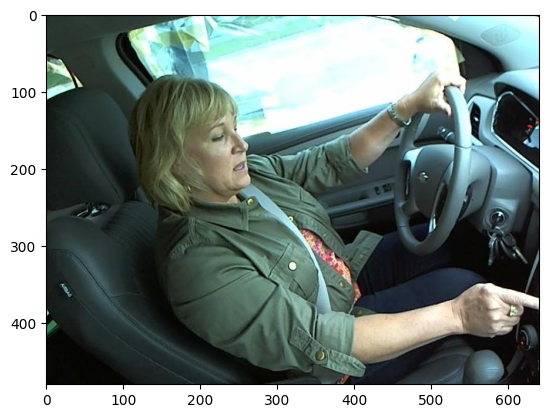

c6: drinking


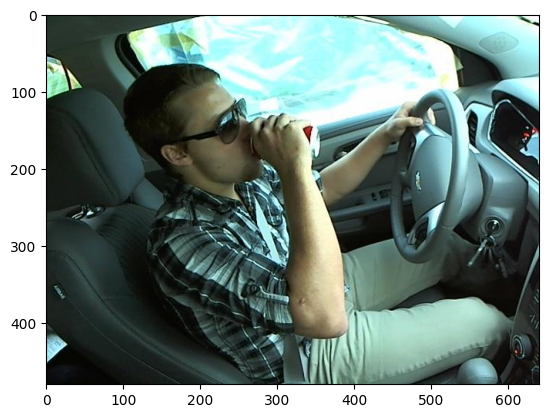

c7: reaching behind


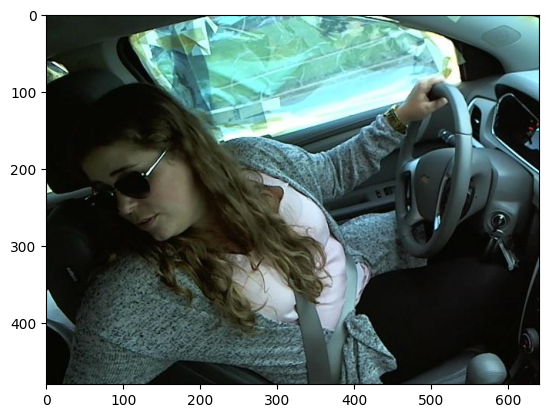

c8: hair and makeup


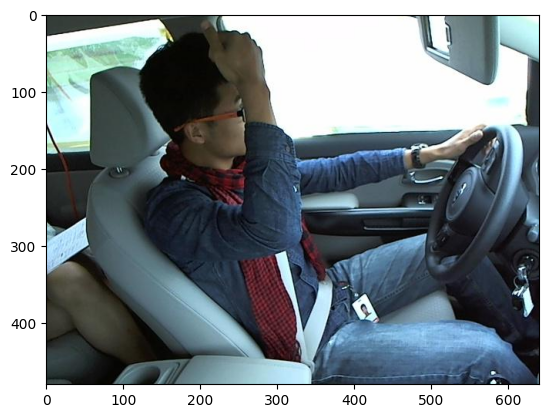

c9: talking to passenger


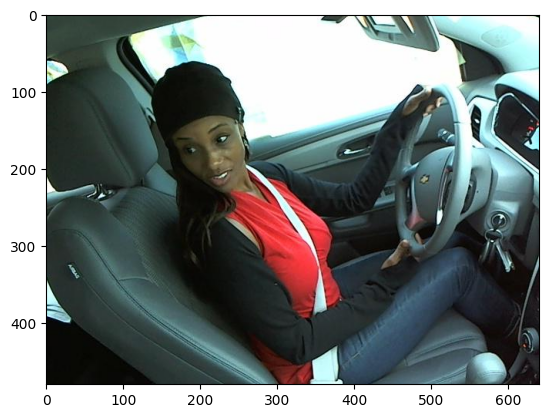

In [ ]:
# Sample Train data images
for class_name, class_type in classes_dict.items():
  print(f"{class_name}: {class_type}")
  path = os.path.join(directory,class_name)
  for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
      RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
      plt.imshow(RGB_img)
      plt.show()
      break

In [ ]:
# Train data image size
img_array.shape

(480, 640, 3)

In [5]:
# Creating a training dataset
training_data = []
i = 0

for x, category in enumerate(classes_dict.keys()):
    path = os.path.join(directory,category)
    class_num = x

    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_img = cv2.resize(RGB_img,(img_size,img_size))
        training_data.append([new_img,class_num])

In [6]:
len(training_data)

22424

In [7]:
# Train-Test Split
random.shuffle(training_data)
x, y = [[] for _ in range(2)]
for features, label in training_data:
    x.append(features)
    y.append(label)

del training_data

x = np.array(x).reshape(-1,img_size,img_size,3)
print(x.shape)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=102)

(22424, 240, 240, 3)


In [ ]:
# Check class distribution in each data group
print("Training Data")
print("No.of rows: {}".format(len(y_train)))
print(pd.DataFrame(y_train, columns=['class']).value_counts(normalize=True))
print("*"*25)
print("Testing Data")
print("No.of rows: {}".format(len(y_test)))
print(pd.DataFrame(y_test, columns=['class']).value_counts(normalize=True))
print("*"*25)

del x,y
gc.collect()

Training Data
No.of rows: 15696
class
0        0.110984
3        0.104613
4        0.103721
6        0.103721
2        0.103338
5        0.103084
1        0.101109
9        0.094929
7        0.089258
8        0.085245
dtype: float64
*************************
Testing Data
No.of rows: 6728
class
0        0.111029
3        0.104637
4        0.103746
6        0.103597
2        0.103300
5        0.103151
1        0.101070
9        0.094976
7        0.089328
8        0.085166
dtype: float64
*************************


178

In [ ]:
# Preprocess Y data
Y_train = utils.to_categorical(y_train,num_classes=10)
Y_test = utils.to_categorical(y_test,num_classes=10)
print(Y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Initialise Model

model = models.Sequential()
## CNN 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(240,240,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))
## CNN 2
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))
## CNN 3
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.5))
# Dense & Output
model.add(Flatten())
model.add(Dense(units = 512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 238, 238, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 238, 238, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 238, 238, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 119, 32)      0         
 D)                                                              
                                                        

In [ ]:
# Callbacks

# Model Checkpoint
filepath = "/content/sample_data/distracted_drver_data/model/best_model_tr.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',patience=5)

In [ ]:
# Train Model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
callback = [early_stopping, checkpoint]
batch_size = 25
n_epochs = 15
results = model.fit(
    x_train,Y_train,
    batch_size=batch_size,epochs=n_epochs,
    verbose=1,
    validation_data=(x_test,Y_test),
    callbacks=callback
)

Epoch 1/15
628/628 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.7620
Epoch 1: val_accuracy improved from -inf to 0.94233, saving model to /content/sample_data/distracted_drver_data/model/best_model_tr.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


628/628 [==============================] - 188s 273ms/step - loss: 0.7508 - accuracy: 0.7620 - val_loss: 0.1978 - val_accuracy: 0.9423
Epoch 2/15
628/628 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9412
Epoch 2: val_accuracy did not improve from 0.94233
628/628 [==============================] - 168s 267ms/step - loss: 0.1853 - accuracy: 0.9412 - val_loss: 0.1785 - val_accuracy: 0.9407
Epoch 3/15
628/628 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9641
Epoch 3: val_accuracy improved from 0.94233 to 0.98662, saving model to /content/sample_data/distracted_drver_data/model/best_model_tr.hdf5
628/628 [==============================] - 168s 268ms/step - loss: 0.1150 - accuracy: 0.9641 - val_loss: 0.0464 - val_accuracy: 0.9866
Epoch 4/15
628/628 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9736
Epoch 4: val_accuracy did not improve from 0.98662
628/628 [==============================] - 168s 267ms/step - loss

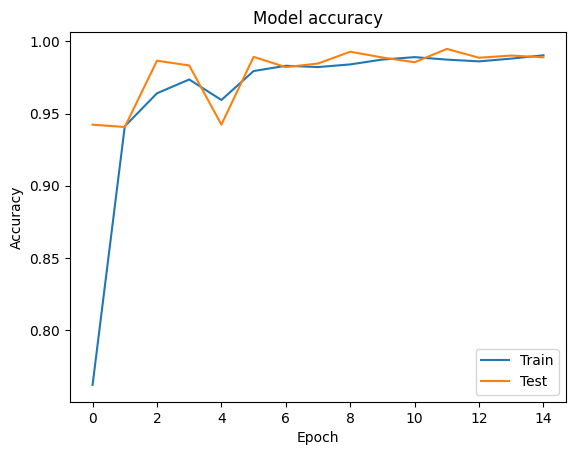

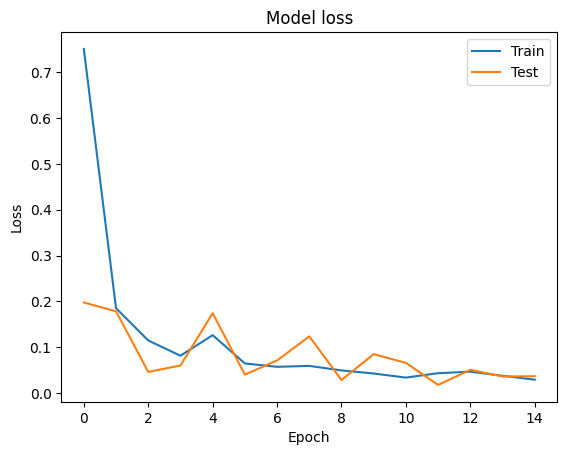

In [ ]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [6]:
# Load Best Model
model = load_model("/content/sample_data/distracted_drver_data/model/best_model_tr.hdf5")

In [9]:
# Prepare and predict -- validation data
chunk_size=10000
file_list = os.listdir(test_directory)
file_count = len(file_list)
overall_pred, overall_classes_pred = [[] for _ in range(2)]

for i in range(0, file_count, chunk_size):
  print("*"*25)
  print(i)
  print(i+chunk_size)
  chunk = file_list[i:i+chunk_size]
  validation_data = []
  for img in chunk:
    img_array = cv2.imread(os.path.join(test_directory, img),cv2.IMREAD_COLOR)
    RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    new_img = cv2.resize(RGB_img,(img_size,img_size))
    validation_data.append(new_img)

  validation_data = np.array(validation_data).reshape(-1,img_size,img_size,3)
  pred = model.predict(validation_data)
  classes_pred = np.argmax(pred, axis=1)
  overall_pred.extend(pred)
  overall_classes_pred.extend(classes_pred)
  del chunk

*************************
0
10000
313/313 [==============================] - 14s 45ms/step
*************************
10000
20000
313/313 [==============================] - 14s 45ms/step
*************************
20000
30000
313/313 [==============================] - 15s 48ms/step
*************************
30000
40000
313/313 [==============================] - 15s 49ms/step
*************************
40000
50000
313/313 [==============================] - 15s 49ms/step
*************************
50000
60000
313/313 [==============================] - 15s 49ms/step
*************************
60000
70000
313/313 [==============================] - 14s 46ms/step
*************************
70000
80000
304/304 [==============================] - 16s 52ms/step


In [10]:
# Number of prediction made
len(overall_classes_pred)

79726

In [21]:
# Create submission data
submission_df = pd.DataFrame()

for i in range(file_count):
  if i%10000==0:
    print(i)
  df = pd.DataFrame(utils.to_categorical(overall_classes_pred[i],num_classes=10), columns=[file_list[i]], index=list(classes_dict.keys())).T
  submission_df = pd.concat([submission_df, df], axis=0)

0
10000
20000
30000
40000
50000
60000
70000


In [24]:
# Format submission data
submission_df.reset_index(inplace=True)
submission_df.rename(columns={'index':'img'}, inplace=True)
submission_df.sample(10)

img   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
13339  img_94793.jpg  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
47854   img_7263.jpg  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
64926  img_40488.jpg  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5514   img_99463.jpg  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
5509   img_68623.jpg  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
30487  img_13905.jpg  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
66558   img_6271.jpg  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
56715  img_51585.jpg  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
79410  img_54948.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
701    img_18830.jpg  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [25]:
# Save submisison data
submission_df.to_csv('swareena_dixit_distracted_driver_detection_submission.csv', index=False)

Checking for Image 4: img_82735.jpg
Predicted Class: operating the radio
Test Image


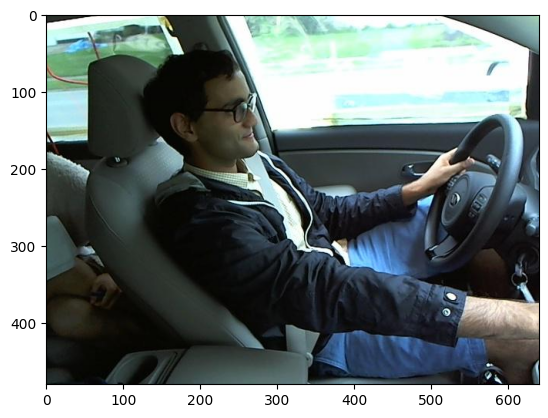

In [67]:
# Check predictions
img_num = 4
img_file = submission_df.loc[img_num,'img']
print(f"Checking for Image {img_num}: {img_file}")
pred_class = submission_df.iloc[[img_num]][classes_dict.keys()].idxmax(axis=1)[img_num]
print(f"Predicted Class: {classes_dict[pred_class]}")
print("Test Image")
img_array = cv2.imread(os.path.join(test_directory, img_file),cv2.IMREAD_COLOR)
RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()